In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


import libraries :

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


Load Dataset from kaggle Data set :

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("architsharma01/loan-approval-prediction-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-approval-prediction-dataset


Now check what files are in that path:

In [4]:
import os

# List the files inside the dataset directory
print("Files:", os.listdir(path))


Files: ['loan_approval_dataset.csv']


Let's print the files to verify

In [5]:

files = os.listdir(path)
print(files)  # Copy the exact file name from here

# Use the correct file name
df = pd.read_csv(os.path.join(path, files[0]))  # or use files[0] if there's only one CSV


['loan_approval_dataset.csv']


In [6]:
df.isnull().sum()


loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

In [7]:
print(df.columns.tolist())


['loan_id', ' no_of_dependents', ' education', ' self_employed', ' income_annum', ' loan_amount', ' loan_term', ' cibil_score', ' residential_assets_value', ' commercial_assets_value', ' luxury_assets_value', ' bank_asset_value', ' loan_status']


In [8]:
# Normalize column names properly
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# View cleaned column names
print("Cleaned column names:\n", df.columns.tolist())


Cleaned column names:
 ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']


In [9]:
# Step 1: Print actual column names before anything else
print("Original columns:\n", df.columns.tolist())

# Step 2: Clean column names (force standard format)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()
print("\nCleaned columns:\n", df.columns.tolist())

# Step 3: Handle missing values (only for columns that exist)
expected_cols = ['gender', 'married', 'dependents', 'education', 'self_employed',
                 'loanamount', 'loan_amount_term', 'credit_history', 'loan_status']

for col in expected_cols:
    if col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].median(), inplace=True)
    else:
        print(f"⚠️ Column not found: {col}")

# Step 4: Encode categorical columns safely
from sklearn.preprocessing import LabelEncoder

cat_cols = ['gender', 'married', 'education', 'self_employed', 'property_area', 'loan_status']
le = LabelEncoder()
for col in cat_cols:
    if col in df.columns:
        df[col] = le.fit_transform(df[col])
    else:
        print(f"⚠️ Skipping encoding for missing column: {col}")

# Step 5: Final check
print("\n✅ Final check — Missing values:\n", df.isnull().sum())


Original columns:
 ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Cleaned columns:
 ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']
⚠️ Column not found: gender
⚠️ Column not found: married
⚠️ Column not found: dependents
⚠️ Column not found: loanamount
⚠️ Column not found: loan_amount_term
⚠️ Column not found: credit_history
⚠️ Skipping encoding for missing column: gender
⚠️ Skipping encoding for missing column: married
⚠️ Skipping encoding for missing column: property_area

✅ Final check — Missing values:
 loan_id                     0
no_of_dependents            0
education                   0
self_employed          

/tmp/ipykernel_35/964016347.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Feature Selection and Train-Test Split:

In [10]:


# Drop loan_id (not useful for prediction)
df.drop('loan_id', axis=1, inplace=True)

# Define X (features) and y (target)
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("✅ Training and testing sets created.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


✅ Training and testing sets created.
X_train shape: (3415, 11)
y_train shape: (3415,)


Model Training & Evaluation:

✅ Accuracy: 0.9778

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       536
           1       0.98      0.96      0.97       318

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.98       854
weighted avg       0.98      0.98      0.98       854



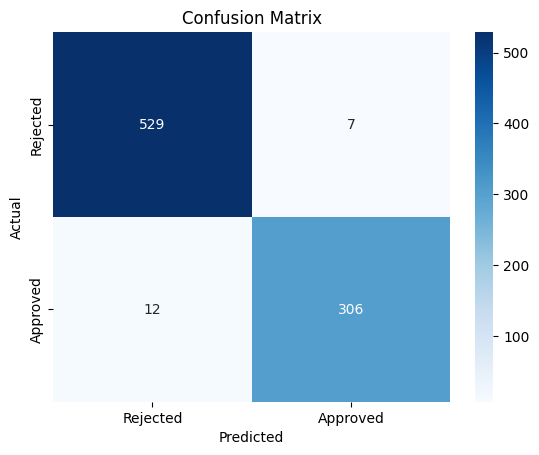

In [11]:


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Rejected', 'Approved'], yticklabels=['Rejected', 'Approved'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Feature Importance:

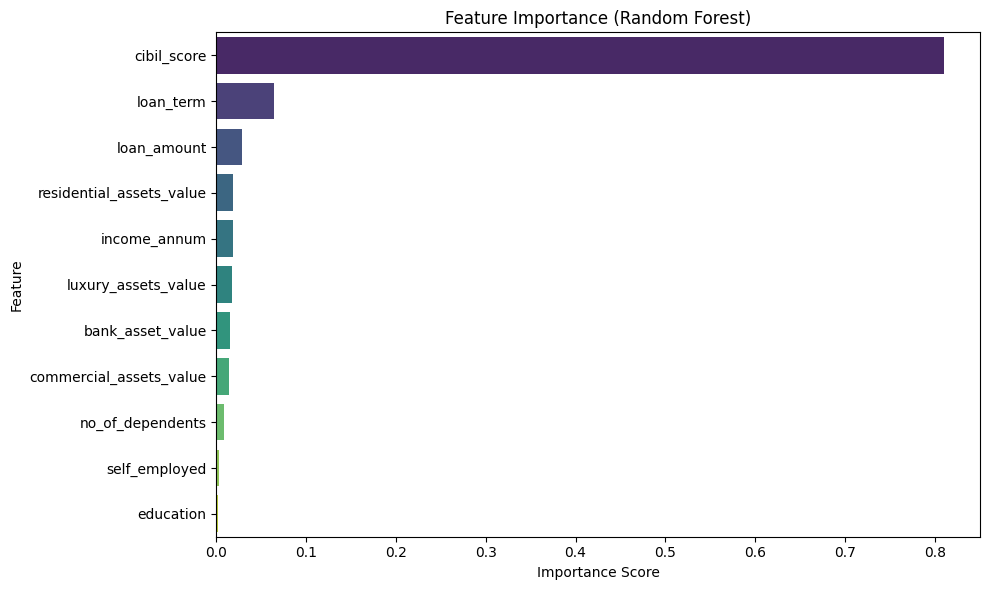

In [12]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create DataFrame and sort
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Hyperparameter Tuning:

In [13]:


from sklearn.model_selection import GridSearchCV

# Define grid of parameters to try
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# GridSearchCV for tuning
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and model
print("✅ Best Parameters Found:\n", grid_search.best_params_)

# Evaluate tuned model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"\n🔍 Accuracy after tuning: {accuracy_score(y_test, y_pred_best):.4f}")


✅ Best Parameters Found:
 {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

🔍 Accuracy after tuning: 0.9778


Save the model to a file:

In [14]:

import joblib

joblib.dump(best_model, 'loan_model.pkl')
print("✅ Model saved as 'loan_model.pkl'")


✅ Model saved as 'loan_model.pkl'
